# Topic Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.lsimodel import LsiModel
from gensim.models.phrases import Phraser
from gensim.matutils import corpus2csc
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel, Phrases
import re
import spacy
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from MulticoreTSNE import MulticoreTSNE as TSNE
import pyLDAvis
import pyLDAvis.gensim
import warnings
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import warnings

np.random.seed(23)

def load_data():
    data_path = Path('./data')
    print('loading ./data/text_filtered_big.csv into dataframe')
    df = pd.read_csv(data_path/'text_filtered_big.csv',index_col=0)
    print('done')
    return df

def elbow_plot(dictionary, corpus, texts, limit, score_type):
    scores = []
    models = []
    for num_topics in tqdm(range(1, limit+1)):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        models.append(lda)
        if score_type=='coherence':
            score = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
        if score_type=='perplexity':
            score = np.exp(lda.log_perplexity(corpus))
        scores.append(score)
    return models,scores

In [2]:
df = load_data().drop_duplicates()

loading ./data/text_filtered_big.csv into dataframe
done


In [3]:
stop_words = stopwords.words('english') #+ ['said','would','also','us','one','two','since','day','jpghttps','people',
                                        #   'school','students','shooting','marjory','stoneman','douglas','high','florida'
                                        #   'parkland','going','get','many','know','like']
df['text_processed'] = df.text.apply(lambda x: ' '.join(word for word in simple_preprocess(x) if word not in stop_words))
stemmer = SnowballStemmer('english')
df['text_processed'] = df.text_processed.apply(lambda x:' '.join(stemmer.stem(word) for word in x.split()))

nlp = spacy.load('en')#('en_core_web_sm')
df['tokens'] = df.text_processed.apply(lambda x:' '.join(t.text for t in nlp.tokenizer(x)))

In [4]:
texts = [row.split() for row in df.tokens]
bigram = Phrases(texts)
bigram_model = Phraser(bigram)
bigrams = [bigram_model[doc] for doc in texts]

In [5]:
all_tokens = [item for sublist in bigrams for item in sublist]
ctr = Counter(all_tokens)
ctr.most_common(20)

[('school', 33473),
 ('said', 20419),
 ('student', 20201),
 ('shoot', 17807),
 ('marjori_stoneman', 9119),
 ('dougla_high', 8470),
 ('peopl', 8216),
 ('one', 8118),
 ('gun', 6996),
 ('cruz', 6229),
 ('say', 6060),
 ('would', 5931),
 ('florida', 5918),
 ('high_school', 5625),
 ('parkland', 5587),
 ('go', 5429),
 ('time', 5347),
 ('report', 5263),
 ('also', 5180),
 ('day', 5139)]

In [6]:
id2word = Dictionary(bigrams)
corpus = [id2word.doc2bow(text) for text in bigrams]

tfidf = TfidfModel(corpus, id2word=id2word)
tfidf_corpus = tfidf[corpus]
low_value = 1e-5
low_value_words = []
for bow in corpus:
    low_value_words += [id for id, value in tfidf[bow] if value < low_value]
id2word.filter_tokens(bad_ids=low_value_words)
new_corpus = [id2word.doc2bow(text) for text in bigrams]
corpus = new_corpus

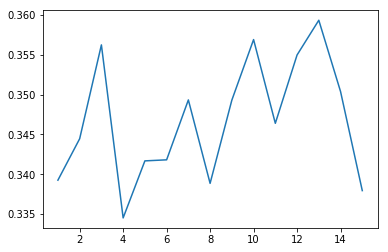

In [11]:
warnings.filterwarnings('ignore')
limit=15
models,scores = elbow_plot(id2word,corpus,bigrams,limit,'coherence')
plt.plot(range(1,limit+1),scores)

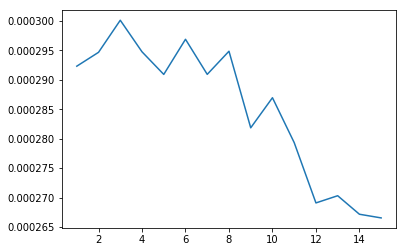

In [12]:
warnings.filterwarnings('ignore')
limit=15
models,scores = elbow_plot(id2word,corpus,bigrams,limit,'perplexity')
plt.plot(range(1,limit+1),scores)

In [17]:
num_topics = 3
warnings.filterwarnings('ignore')
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
#lda = LsiModel(corpus=tfidf_corpus, id2word=id2word, num_topics=10)
lda_corpus = lda[corpus]
for top in lda.print_topics():
    print(top)

(0, '0.018*"school" + 0.018*"student" + 0.011*"shoot" + 0.011*"said" + 0.006*"peopl" + 0.006*"gun" + 0.005*"marjori_stoneman" + 0.005*"one" + 0.004*"high_school" + 0.004*"go"')
(1, '0.026*"school" + 0.017*"said" + 0.013*"shoot" + 0.012*"student" + 0.009*"marjori_stoneman" + 0.008*"dougla_high" + 0.006*"cruz" + 0.006*"peopl" + 0.005*"one" + 0.005*"florida"')
(2, '0.021*"school" + 0.012*"said" + 0.011*"shoot" + 0.008*"student" + 0.006*"one" + 0.006*"gun" + 0.005*"cruz" + 0.005*"report" + 0.005*"offic" + 0.005*"would"')


In [18]:
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
vis = pyLDAvis.gensim.prepare(lda,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.026595  0.001380       1        1  43.240555
2      0.011963 -0.021324       2        1  29.480358
1      0.014632  0.019943       3        1  27.279081, topic_info=     Category          Freq              Term         Total  loglift  logprob
term                                                                         
195   Default  31912.000000            school  31912.000000  30.0000  30.0000
191   Default  19309.000000              said  19309.000000  29.0000  29.0000
46    Default   5778.000000              cruz   5778.000000  28.0000  28.0000
129   Default   8738.000000  marjori_stoneman   8738.000000  27.0000  27.0000
61    Default   8065.000000       dougla_high   8065.000000  26.0000  26.0000
313   Default   5060.000000            report   5060.000000  25.0000  25.0000
516   Default   3174.000000    broward_counti   3174.000000  24.0000  24.0000
145   Default   4421.000000             offic   4421.000000  23.0000  23.0000
49    Default   1927.000000            deputi   1927.000000  22.0000  22.0000
1241  Default   1638.000000          peterson   1638.000000  21.0000  21.0000
202   Default  17307.000000             shoot  17307.000000  20.0000  20.0000
140   Default   1997.000000       nikola_cruz   1997.000000  19.0000  19.0000
1245  Default   2443.000000             polic   2443.000000  18.0000  18.0000
690   Default   1865.000000        law_enforc   1865.000000  17.0000  17.0000
380   Default   3459.000000            famili   3459.000000  16.0000  16.0000
1353  Default   2028.000000      parkland_fla   2028.000000  15.0000  15.0000
666   Default   1627.000000          investig   1627.000000  14.0000  14.0000
3395  Default    724.000000     wednesday_feb    724.000000  13.0000  13.0000
830   Default   2529.000000           shooter   2529.000000  12.0000  12.0000
56    Default   1888.000000          district   1888.000000  11.0000  11.0000
829   Default   1094.000000     sheriff_offic   1094.000000  10.0000  10.0000
335   Default   2128.000000            accord   2128.000000   9.0000   9.0000
1216  Default   1198.000000            israel   1198.000000   8.0000   8.0000
889   Default    851.000000           walkout    851.000000   7.0000   7.0000
1009  Default   1057.000000           suspect   1057.000000   6.0000   6.0000
218   Default  19859.000000           student  19859.000000   5.0000   5.0000
146   Default   1709.000000            offici   1709.000000   4.0000   4.0000
196   Default    731.000000    school_resourc    731.000000   3.0000   3.0000
401   Default   5498.000000       high_school   5498.000000   2.0000   2.0000
1891  Default   1104.000000    former_student   1104.000000   1.0000   1.0000
...       ...           ...               ...           ...      ...      ...
767    Topic3    174.593719   premedit_murder    270.198334   0.8624  -7.7558
1009   Topic3    527.843201           suspect   1057.243652   0.6044  -6.6494
1303   Topic3    386.324188           brother    740.537109   0.6484  -6.9616
1245   Topic3   1003.491150             polic   2443.403564   0.4091  -6.0070
830    Topic3    984.949707           shooter   2529.037354   0.3560  -6.0256
218    Topic3   4804.551270           student  19859.125000  -0.1200  -4.4409
385    Topic3   1846.463135           florida   5864.096680   0.1435  -5.3972
679    Topic3    448.283142        kill_peopl    944.739563   0.5536  -6.8128
401    Topic3   1718.513428       high_school   5498.307129   0.1361  -5.4690
230    Topic3   1599.599365              time   5016.209961   0.1561  -5.5407
161    Topic3   2247.117188             peopl   8037.072754   0.0246  -5.2008
94     Topic3   1292.402222               get   3881.472168   0.1993  -5.7540
333    Topic3   1012.181091          year_old   2869.591309   0.2570  -5.9984
313    Topic3   1537.403442            report   5060.789551   0.1076  -5.5804
115    Topic3   1290.